<img width="5000" style="float:center;" src="figures/TVB_Node8_banner.png" />

<h1 align="center"><font size="7" face="arial" color="#73ACCD">Hands-On: TVB Clinical Application</font></h1>
<h2 align="center"><font size="6" face="arial" color="#73ACCD">Modeling pathological brain activity: example of epilepsy</font></h2>

<br>
<h2 align="center"><font size="5" face="arial">August 31, 2019</font></h2>

<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Julie Courtiol</font></span></h3>
<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial">Charité Universitätsmedizin Berlin, Dept of Neurol, Brain Simulation Section, Berlin, Germany</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:julie.courtiol@charite.de">julie.courtiol@charite.de</a></font></span></h3>

<h1><font size="6" face="arial" color="#386766">Context</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">TVB can be used to model <b>large-scale epileptic seizure dynamics</b>. Using relevant neural mass models, TVB allows to ask multiple questions such as the <b>localisation of the Epileptogenic Zone</b> or the <b>validity of different neuroimaging modalities</b> to assess the epileptogenicity of a brain structure. Here, we will present an example of such a modelisation.</font></div></p>

<br><h1><font size="6" face="arial" color="#386766">Objectives</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">The main goal of this tutorial is to provide a clear understanding of <b>how we can reproduce clinically relevant senarios</b> such as the modelisation of <b>propagation of an epileptic seizure</b> in the human brain, <b>surgical resection</b> of brain regions, and <b>electrical stimulation</b> of a brain region that can trigger a seizure.</font></div></p>

<br><h1><font size="6" face="arial" color="#386766">How to do it with TVB?</font></h1> 
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we want to do is to import the modules we will need for a simulation.</font></div></p>

In [1]:
%pylab nbagg

# Import a bunch of stuff to ease command line usage.
from tvb.simulator.lab import *
import tvb.datatypes.projections as projections

import numpy as np
import time as tm
from mpl_toolkits.mplot3d import Axes3D

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


<h1><font size="6" face="arial" color="black">1. Build a virtual epileptic patient</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">In the following, we will model a random patient suffering from a <b>bilateral temporal lobe epilepsy (TLE)</b> using the Default TVB Subject dataset.</font></div></p> <br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The basic simulation of TVB consists of 5 main components. Each of these components is an object within TVB:</font></div></p>

<h2><font size="5"face="arial" color="black"> 1.1 Anatomical Structural Connectivity</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start with loading and visualizing the structural connectivity matrix of the patient.</font></div></p>

<IPython.core.display.Javascript object>


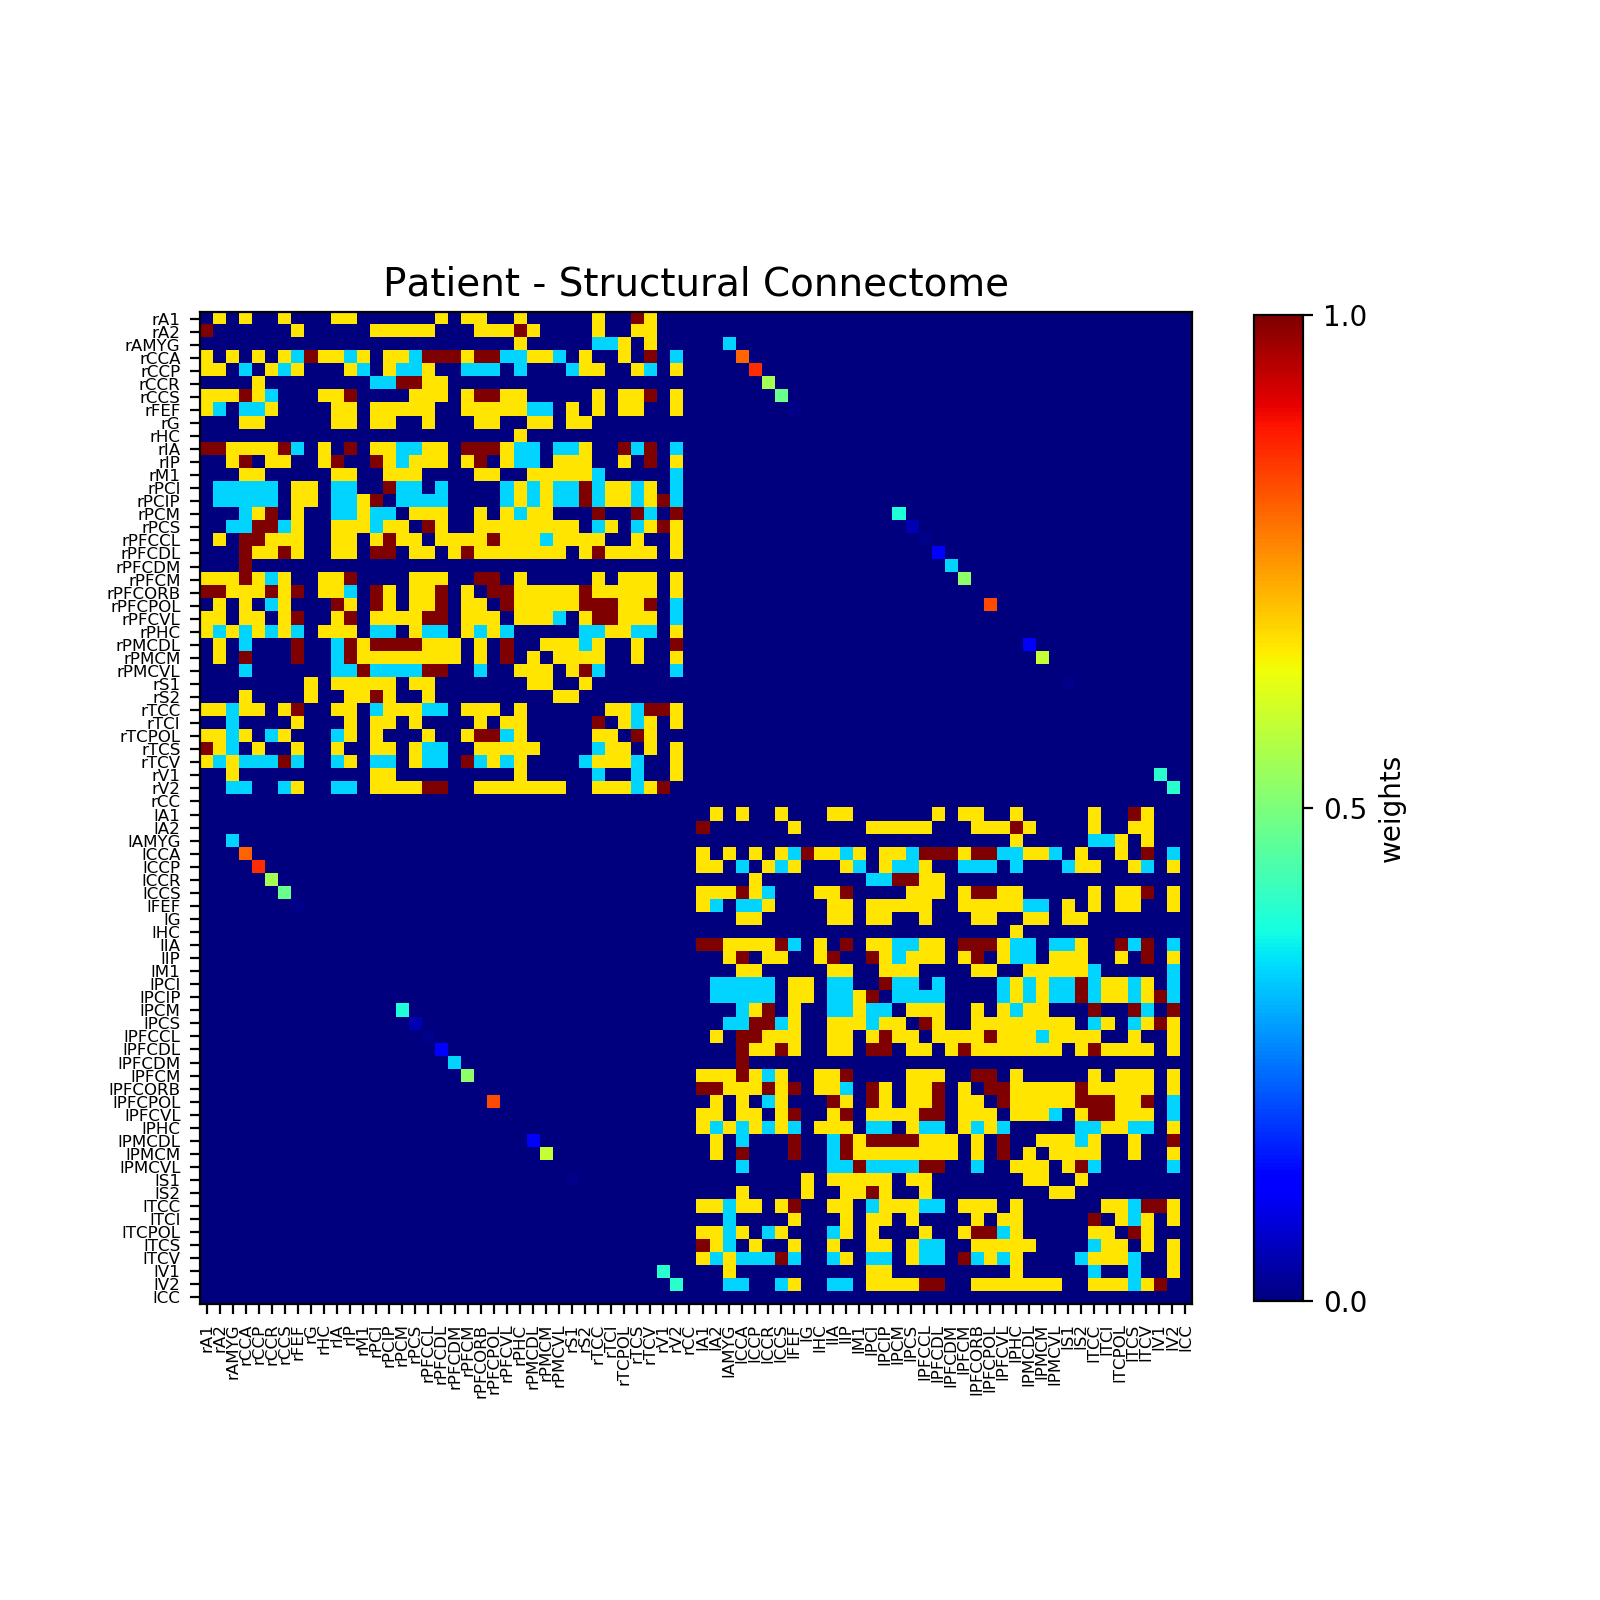

In [12]:
# Initialise a Connectivity.
con = connectivity.Connectivity.from_file("connectivity_76.zip")       
nregions = len(con.areas)                                  #number of regions
con.weights = con.weights - con.weights * np.eye(nregions) #remove self-connections
con.weights = con.weights / np.abs(con.weights.max())      #normalize
con.speed = np.inf                                         #set the conduction speed to infinity (i.e., no time delay)
con.configure()

# Visualization.
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Patient - Structural Connectome', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, 0.5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=6, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=6)
show()

<h2><font size="5" face="arial" color="black"> 1.2 Model</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In order to model epilepsy, we choose the <b>Epileptor</b> which is a phenomenological neural mass model able to realistically reproduce <b>epileptic seizure dynamics</b> such as recorded with intracranial EEG electrodes (see <b>Jirsa et al., Brain 2014</b>):</font></div></p>

\begin{eqnarray}
    \dot{x}_{1} &=& y_{1} - f_{1}(x_{1}, x_{2}) - z + I_{ext_{1}}\\
    \dot{y}_{1} &=& 1 - 5x_{1}^{2} - y_{1}\\
    \dot{z} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1} - x_{0}) - z)\\
    \dot{x}_{2} &=& - y_{2} + x_{2} - x_{2}^{3} + I_{ext_{2}} + 0.002g(x_{1}) - 0.3 (z - 3.5)\\
    \dot{y}_{2} &=& \dfrac{1}{\tau_{2}} \ (-y_{2} + f_{2}(x_{2}))\\
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">where $\tau_{0}=2857$, $I_{ext_{1}}=3.1$, $I_{ext_{2}}=0.45$. The parameter $\pmb{x_{0}}$ controls the degree of <b>epileptogenicity</b> (or excitability) of the node:

<br>
<ul><li>if $\pmb{x_{0} \geqslant x_{0, c}}$, the Epileptor can trigger seizures and is said <b>epileptogenic</b>,</li>

<br><li>inversely, if $\pmb{x_{0} < x_{0, c}}$, the Epileptor does not trigger seizure and is said <b>not epileptogenic</b> (or in its "healthy" equilibrium state).</li></ul>

<img width="500" style="float:center;" src="figures/epileptor_x0.png"/>


<br>See equations page 8 in Jirsa et al. (2014) for more details on the model.</font></div></p><br>


In [13]:
# Initialise a Model.
epi = models.Epileptor(Ks=1., r=0.00015) # in Jirsa et al. (2014): r = 1/ \tau_0

# Set initial conditions.
epi.state_variable_range["x1"] = [-5, -3]
epi.state_variable_range["y1"] = [-50, -50]
epi.state_variable_range["z"] = [4., 6.]
epi.state_variable_range["x2"] = [-1.1, -1.1]
epi.state_variable_range["y2"] = [0.001, 0.01]

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can refine the network pathology of the patient by including the clinical hypothesis about its <b>Epileptogenic Network</b>. To this end, we define a <b>spatial map of epileptogenicity</b> where each network's node <i>i</i> is characterized by an excitability value $\pmb{x_{0,i}}$, which quantifies the ability of the node to trigger a seizure. 
<br>We set:
<ul>
<li>the hippocampus (rHC, region 9 and lHC, region 47) as well as the amydala (rAMYG, region 2 and lAMYG, region 40)
as part of the <b>Epileptogenic Zone (EZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-0.75</b> for the rHC and <b>-1.65</b> for the lHC and l-rAMYG,</li> 
<li>we also add two lesser epileptogenic regions: the parahippocampal (lPHC, region 62) and the temporal pole (lTPOL, region 70) as part of the <b>Propagation Zone (PZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-1.78</b> and <b>-1.81</b>, respectively,</li>
<li>and all the other regions (or <b>Non-Involved Zone, NIZ</b>) are set to <b>-2.6</b>.</li>
</ul>

<img width="250" style="float:center;" src="figures/epi_map.png" />

In [14]:
# Define a heatmap.
epi.x0 = np.ones(nregions) * (-2.6)            #NIZ
epi.x0[[9]] = np.ones((1)) * (-0.75)           #EZ 
epi.x0[[47, 2, 40]] = np.ones((3)) * (-1.65)   #EZ 
epi.x0[[62]] = np.ones((1)) * (-1.78)          #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)          #PZ 

<h2><font size="5"face="arial" color="black"> 2.3 Coupling function</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We couple the Epileptors by <b>permittivity coupling</b> (see <b>Proix et al., 2014</b>), which quantifies the influence of neuronal fast discharges $x_{1,j}$ of a remote region $j$ on the local slow permittivity variable $z_{i}$ of region $i$ via a linear <b>difference coupling</b> function, allowing the spread of the seizure through the network by recruiting regions that are not in the EZ.</font></div></p>

\begin{eqnarray}
    \dot{x}_{1,i} &=& y_{1,i} - f_{1}(x_{1,i}, x_{2,i}) - z_{i} + I_{ext_{1}}\\
    \dot{y}_{1,i} &=& 1 - 5x_{1,i}^{2} - y_{1,i}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1,i} - x_{0,i}) - z_{i} \color{red}{- K_{s} * G \ \sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i}))}\\
    \dot{x}_{2,i} &=& - y_{2,i} + x_{2,i} - x_{2,i}^{3} + I_{ext_{2}} + 0.002g(x_{1,i}) - 0.3 (z_{i} - 3.5)\\
    \dot{y}_{2,i} &=& \dfrac{1}{\tau_{2}} \ (-y_{2,i} + f_{2}(x_{2,i}))\\
\end{eqnarray}

In [15]:
# Initialise a Coupling function.
G = -0.25      #global (long-range) coupling strength
con_coupling = coupling.Difference(a=G)

<h2><font size="5"face="arial" color="black"> 2.4 Integrator</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We employ a standard <b>Heun method</b> with an integration time step of <b>0.05</b>. <b>Additive white Gaussian noise</b> is introduced in the state-variables $\pmb{x_{2,i}}$ and $\pmb{y_{2,i}}$ with 0 mean and variance <b>0.00025</b>.</font></div></p>

In [16]:
# Initialise an Integrator scheme.
dt = 0.05               #integration steps [ms]
nsigma = 0.00025        #standard deviation of the noise

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma, nsigma, 0.])) 
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

<h2><font size="5"face="arial" color="black"> 2.5 Monitors</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Here, we will select (1) a simple data reduction monitor and (2) a biophysical measurement process to relate the simulated neural activity to recent epilepsy studies: 

<ol type="1">
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms,</li>
<li>the <b>iEEG</b> monitor generates SEEG recordings.</li>
</ol>
</font></div></p>

In [20]:
# Initialise some Monitors with period in physical time.
#Temporal Average
mon_tavg = monitors.TemporalAverage(period=1) #in ms

#SEEG
#Load the default region mapping
rm = region_mapping.RegionMapping.from_file("regionMapping_16k_76.txt")
pm = projections.ProjectionMatrix.from_file("projection_seeg_588_surface_16k.npy")

mon_seeg = monitors.iEEG.from_file(
            sensors_fname="seeg_588.txt",
            projection_fname="projection_seeg_588_surface_16k.npy",
            region_mapping=rm,
            period=1.)

what_to_watch = (mon_tavg, mon_seeg)

ReaderException: Could not read from /anaconda2/lib/python2.7/site-packages/tvb_data-1.5.5-py2.7.egg/tvb_data/projectionMatrix/projection_seeg_588_surface_16k.npy file

***

<br><h1 align="center"><font size="6"face="arial" color="black">Go! Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can then configure and run the <b>Simulator</b>.</font></div></p>

In [117]:
# Initialise the Simulator.
sim = simulator.Simulator(model=epi,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)

sim.configure()

  ERROR  Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)


Simulator(bound=False, value=None)

In [118]:
# Starting simulation.
print("Starting simulation...")
tic = tm.time()
(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000) 

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for92.1449370384


***

<br><h1 align="center"><font size="6"face="arial" color="black">Visualize our simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">And finally, we can look at the results of our simulation in terms of time series:</font></div></p>

In [119]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)

<IPython.core.display.Javascript object>


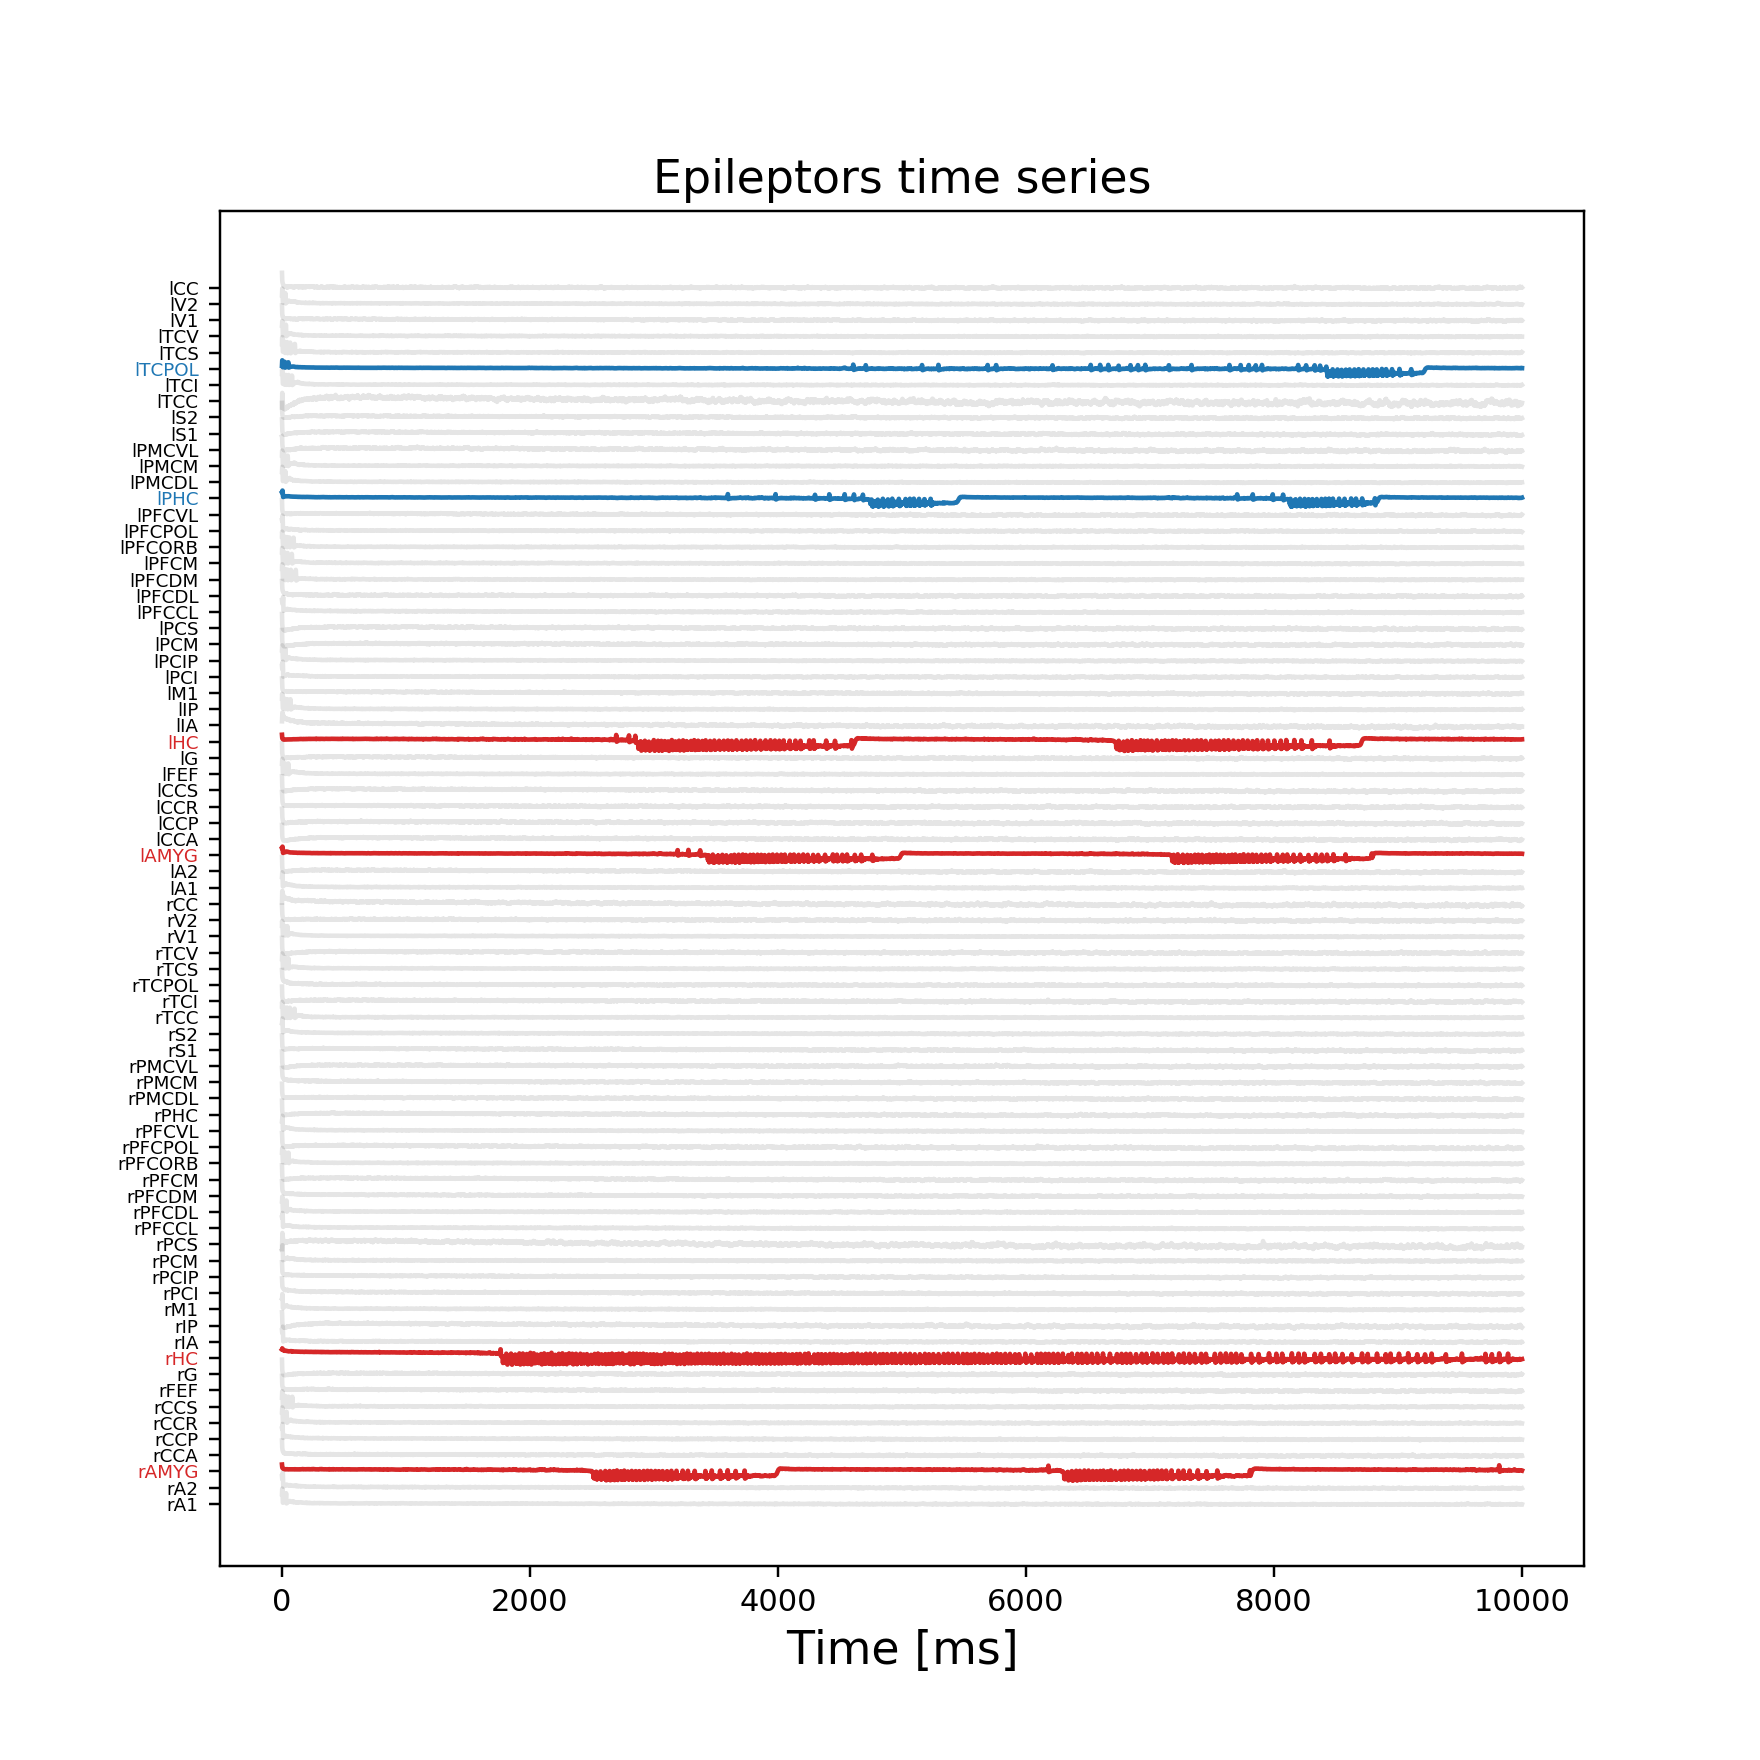

In [120]:
# Plot neural activity time series.
fig, ax  = subplots(figsize=(8,8))

ax.plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'k', alpha=0.1)
title('Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)

EZs = [9, 47, 2, 40]
for iez, ez in enumerate(EZs):
    ax.plot(ttavg[:], tavg[:, 0, EZs[iez], 0] + EZs[iez], 'C3')
    ax.get_yticklabels()[EZs[iez]].set_color('C3')

PZs = [62, 70]
for ipz, pz in enumerate(PZs):
    ax.plot(ttavg[:], tavg[:, 0, PZs[ipz], 0] + PZs[ipz], 'C0')
    ax.get_yticklabels()[PZs[ipz]].set_color('C0')
    
show()

<IPython.core.display.Javascript object>


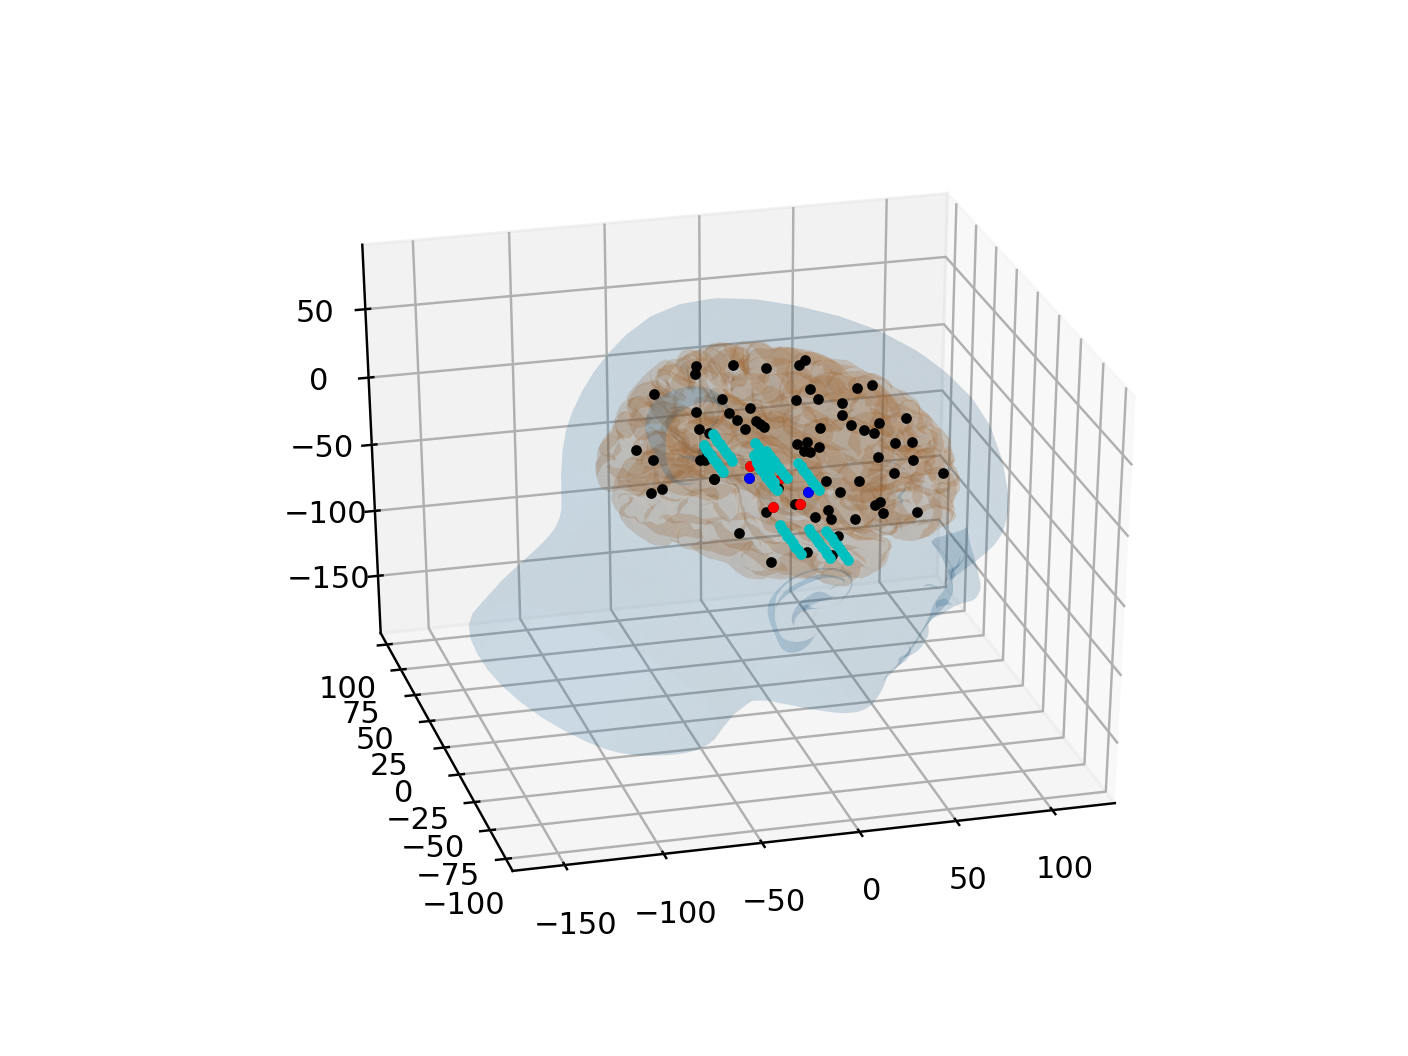

In [121]:
# Visualize patient's electrodes.
figure()
ax = subplot(111, projection='3d')

# ROI centers as black circles
x, y, z = con.centres.T
ax.plot(x, y, z, 'ko', markersize=2.5)

x_ez, y_ez, z_ez = con.centres[EZs].T
ax.plot(x_ez, y_ez, z_ez, 'ro', markersize=2.5)
x_pz, y_pz, z_pz = con.centres[PZs].T
ax.plot(x_pz, y_pz, z_pz, 'bo', markersize=2.5)

# SEEG sensors as blue circles
contacts = np.r_[np.arange(27, 36), np.arange(321, 330), #B(rHC) - B'(lHC)
                 np.arange(36, 45), np.arange(330, 339), #C(rHC) - C'(lHC)
                 np.arange(18, 27), np.arange(312, 321), #NA(rA) - NA'(lA)
                 np.arange(339, 348), #GPH'(lPHC)
                 np.arange(579, 587), #T' (lTl ant)
                 np.arange(294, 303), #TP'(lTP)
                 np.arange(303, 312) # TB' (lTl basalis)
                  ]
x, y, z = mon_seeg.sensors.locations[contacts].T
ax.plot(x, y, z, 'co', markersize=2.5)

# Plot boundary surface
face = surfaces.FaceSurface(load_default=True)
face.configure()

surf=surfaces.Surface(load_default=True)
surf.configure()

x, y, z = face.vertices.T
ax.plot_trisurf(x, y, z, triangles=face.triangles, alpha=0.1, edgecolor='none')

x, y, z = surf.vertices.T
ax.plot_trisurf(x, y, z, triangles=surf.triangles, alpha=0.1, edgecolor='none')

# Set rotation angle to 30 degrees
ax.view_init(elev=30, azim=-105)

show()

<IPython.core.display.Javascript object>


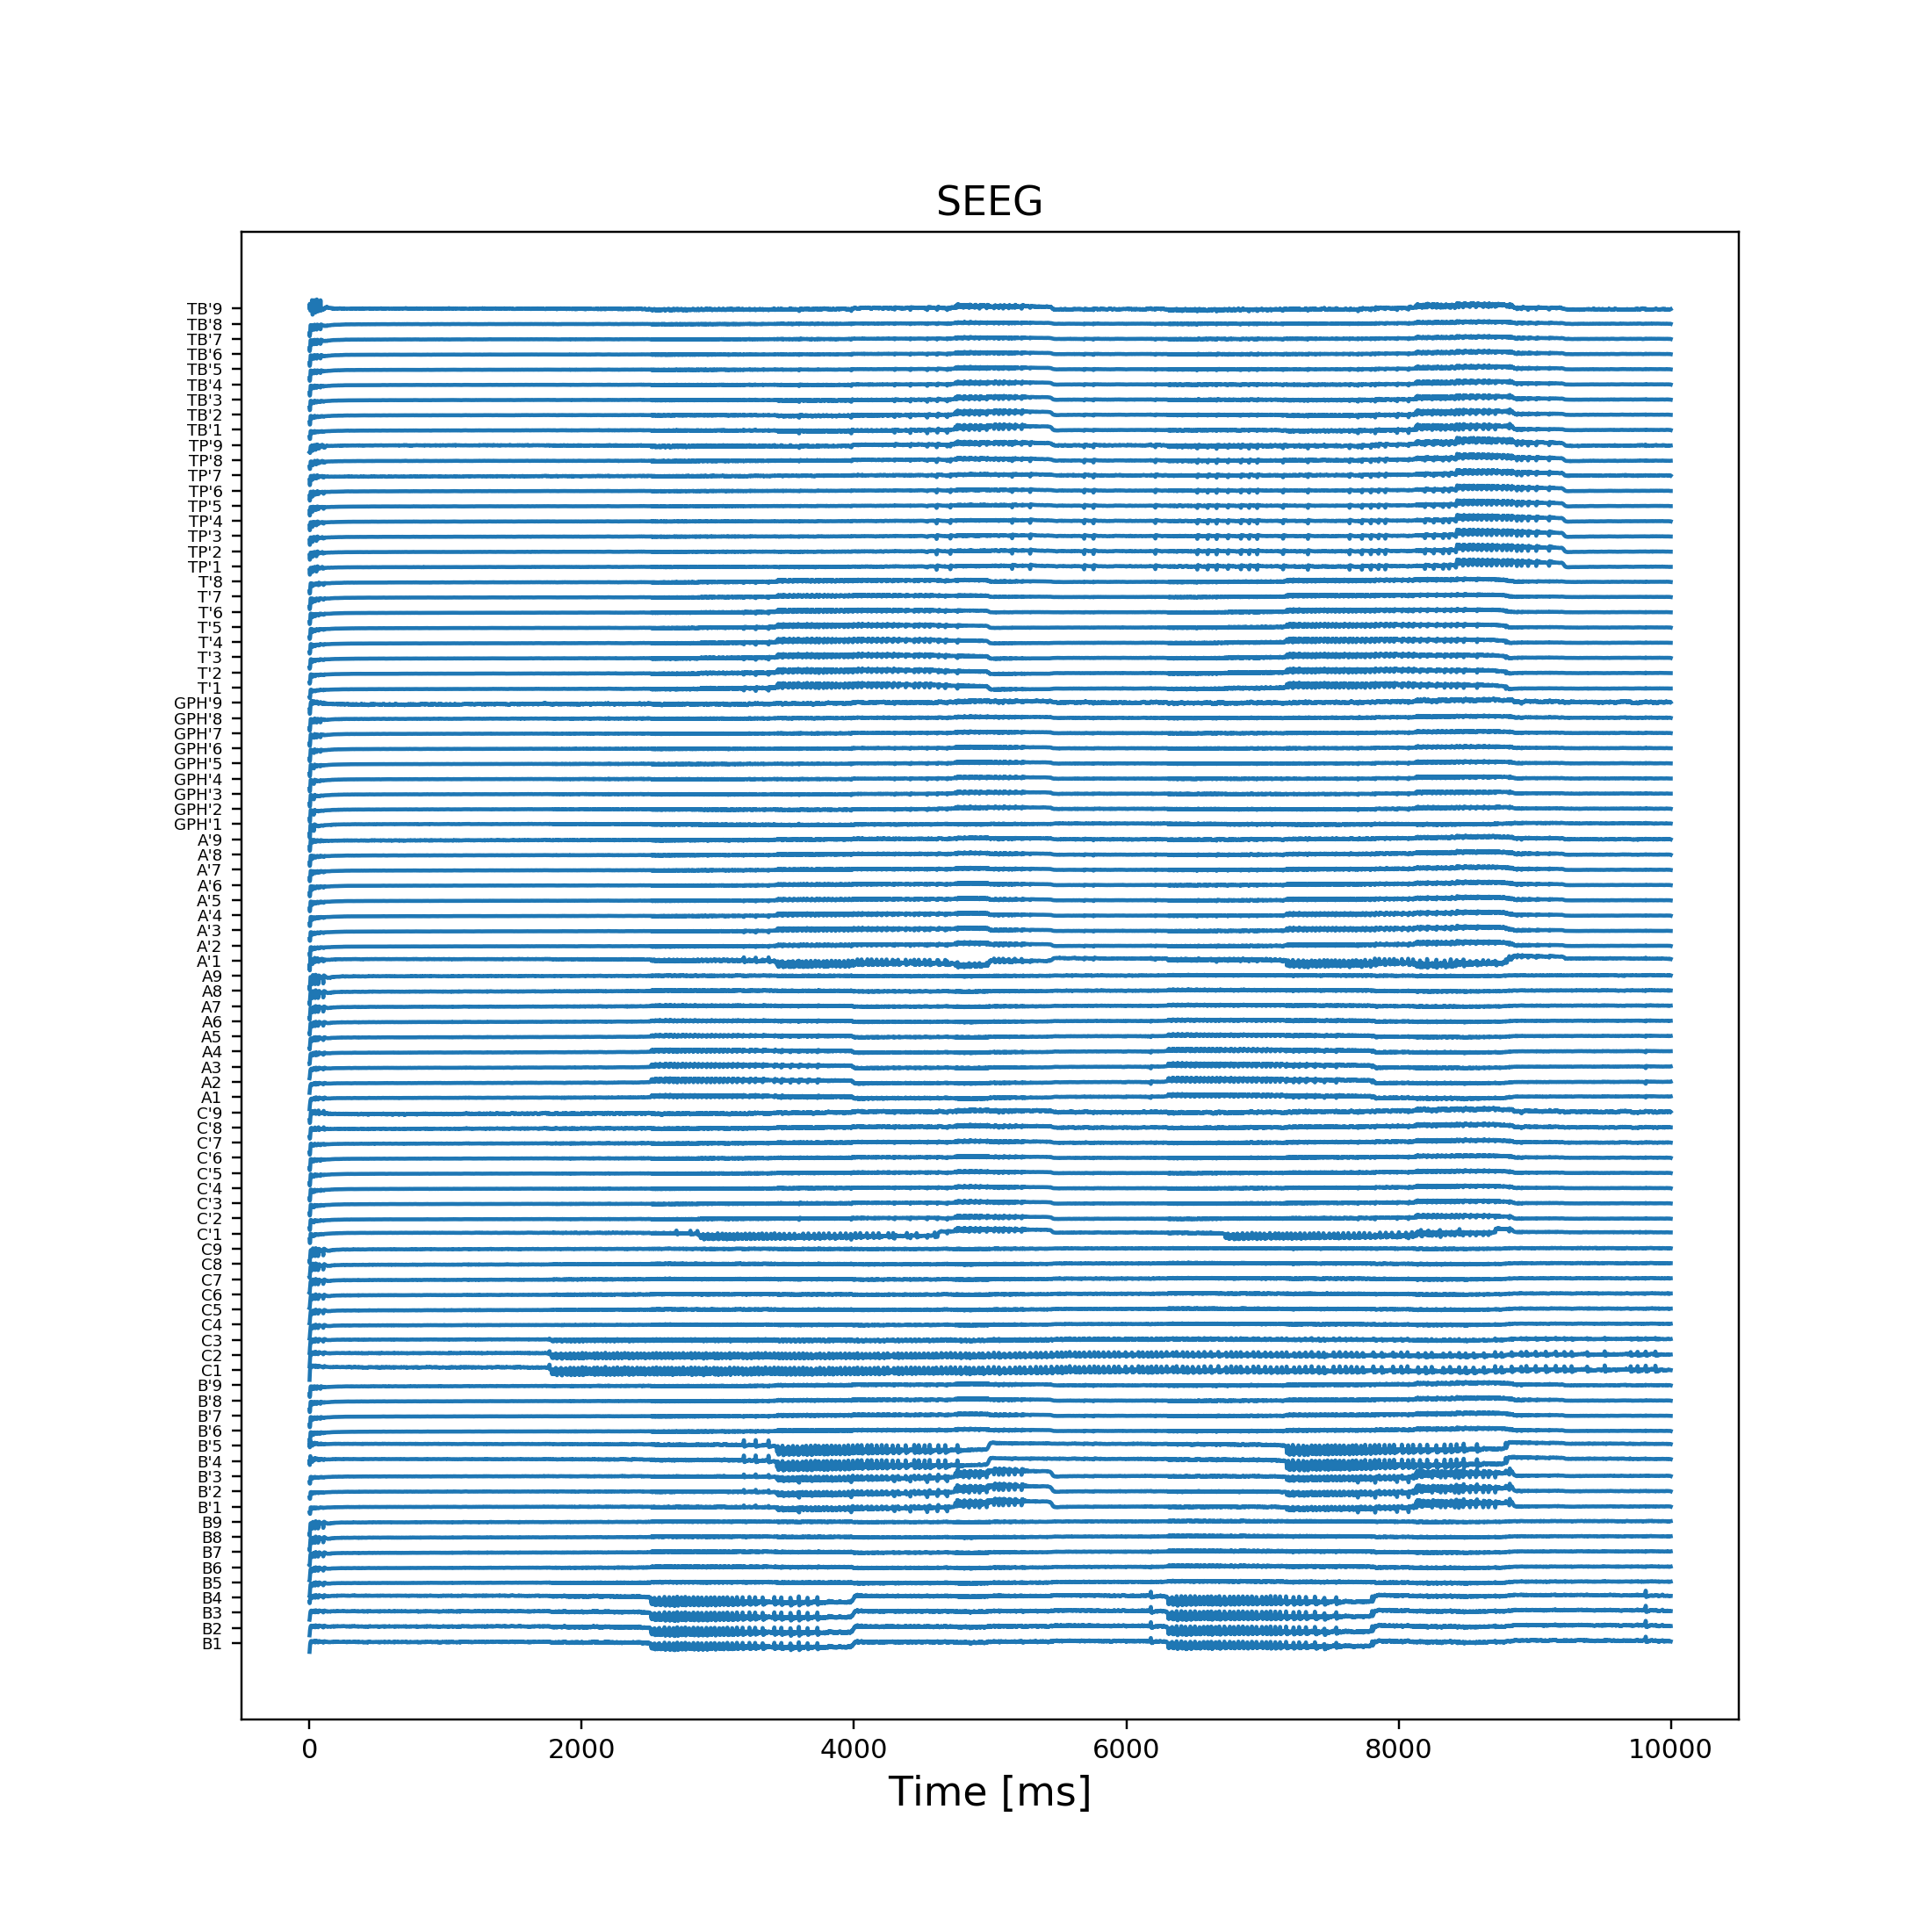

In [122]:
# Plot some of the SEEG sensors.
figure(figsize=(10,10))
plot(tseeg[:], seeg[:, 0, contacts, 0] + np.r_[:len(contacts)], 'C0')
yticks(np.r_[:len(contacts)], mon_seeg.sensors.labels[contacts], fontsize=6)
title('SEEG', fontsize=15)
xlabel('Time [ms]', fontsize=15)
show()

<h1><font size="6" face="arial" color="black">2. Modeling surgical resection</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">Surgical resection is used for around 20% of epileptic patient whose seizures are drug- resistant. We will simulate the hypothetic case of a surgical resection of the Epileptogenic Zone.</font></div></p><br>

<h3 align="left"><font size="5"face="arial" color="black">2.1 Resection</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We set all the connections to the Epileptogenic Zone to 0 in the connectivity matrix. The resection of the Epileptogenic Network is not complete, will it be enough to prevent seizures?</font></div></p>

<IPython.core.display.Javascript object>


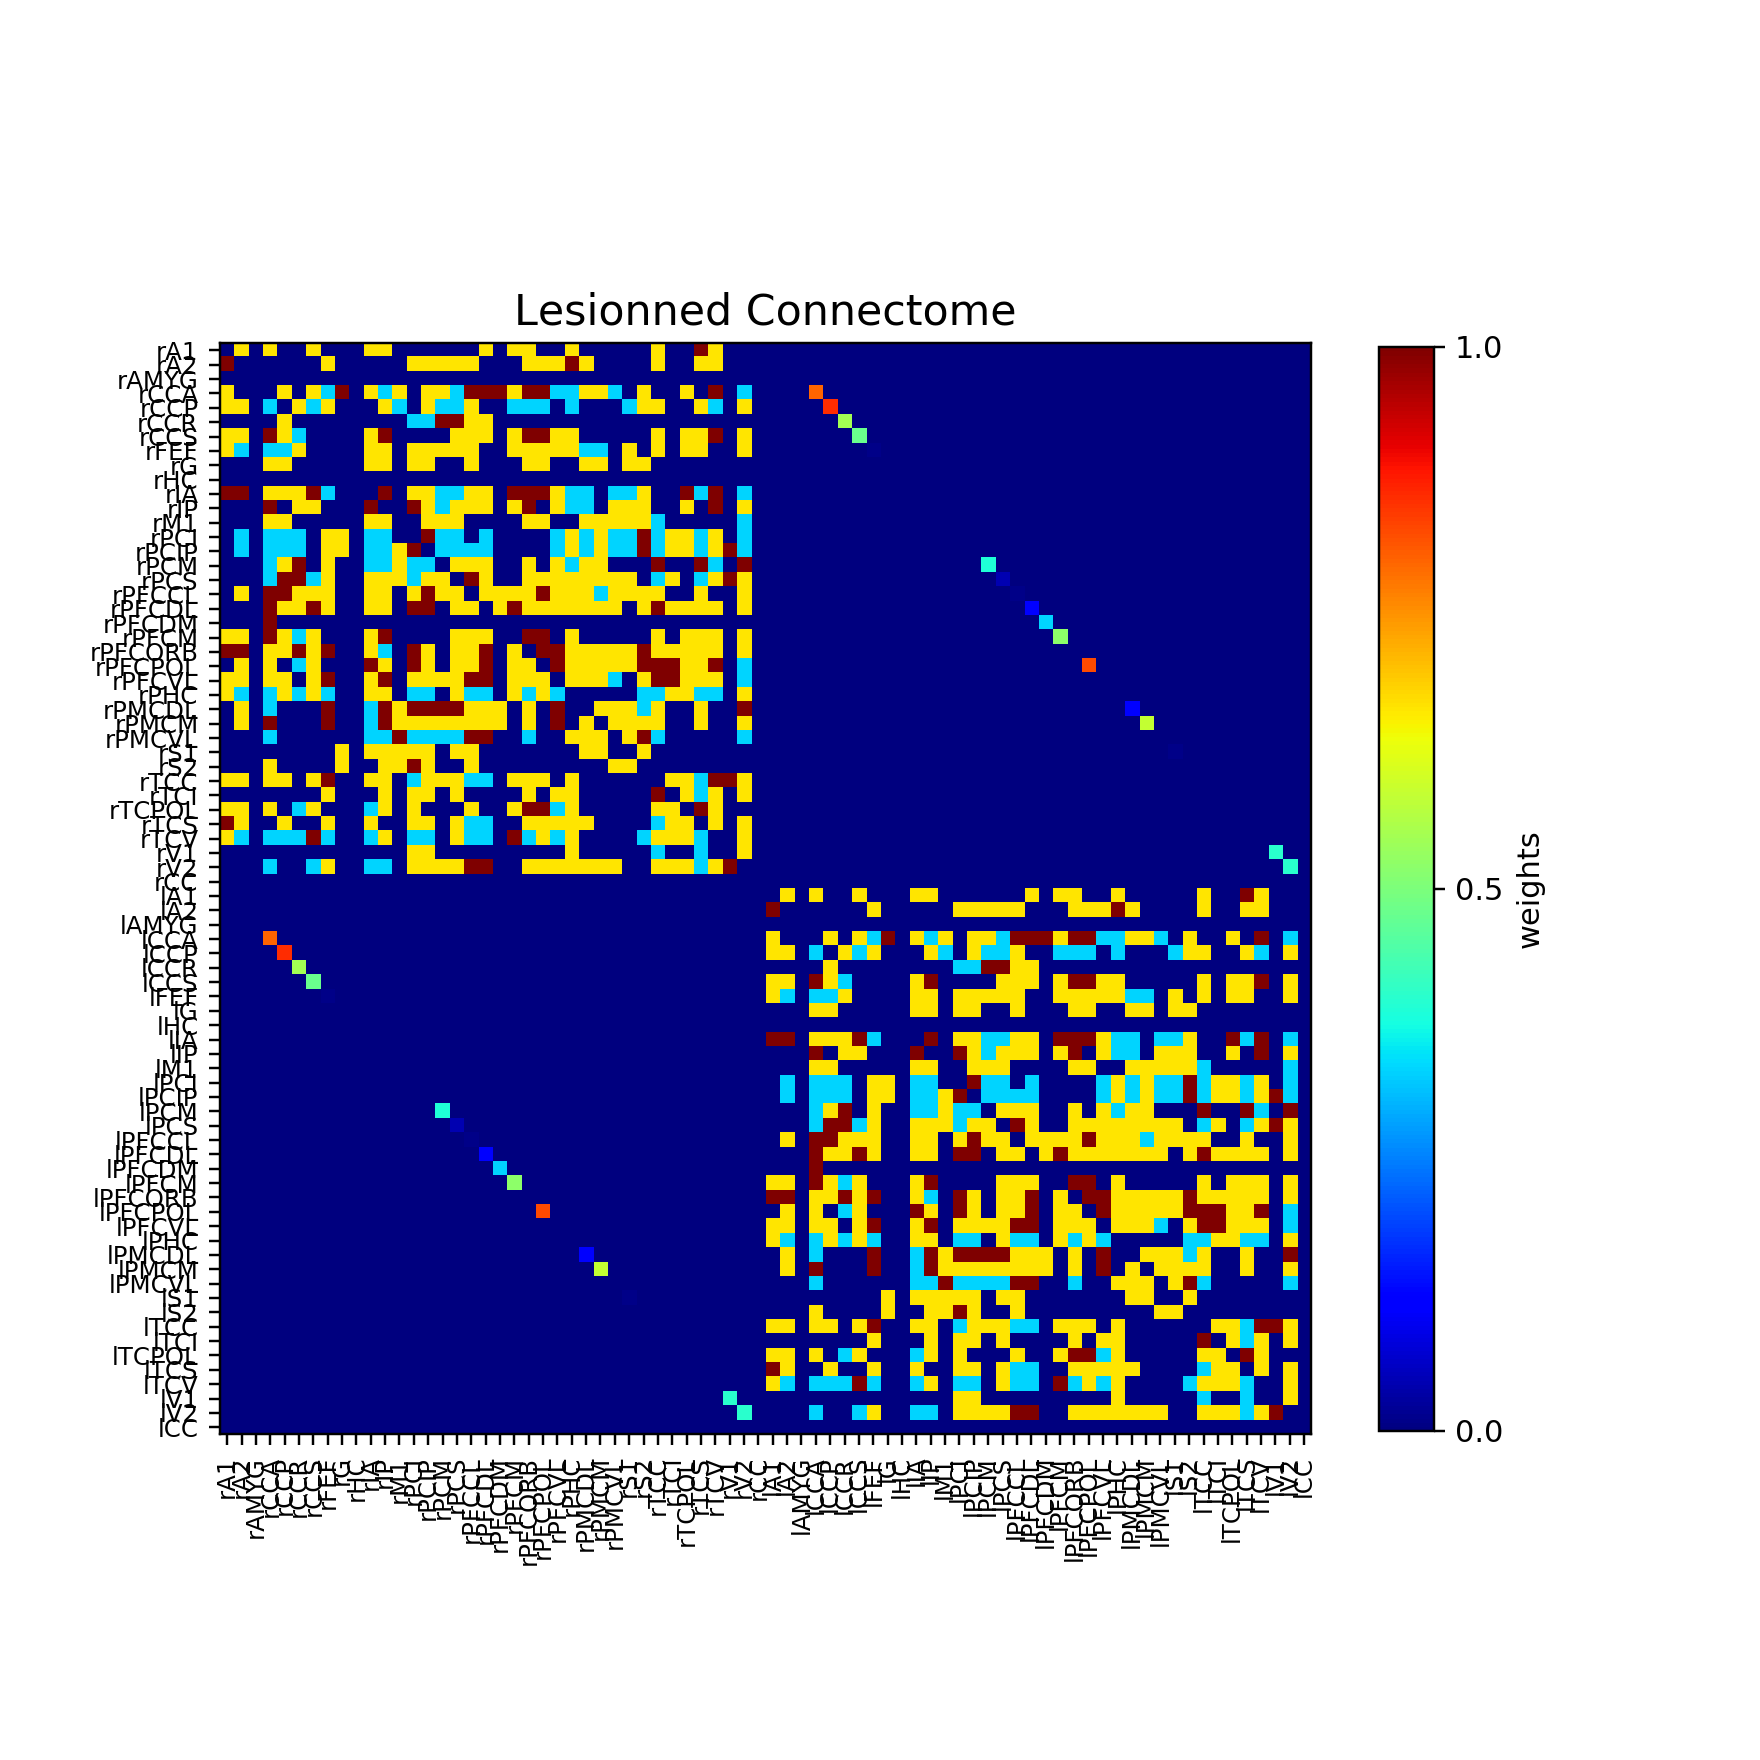

In [123]:
# All the incoming and outcoming connections of the resected regions are removed:
con.weights[:, [9, 47, 2, 40]] = 0.
con.weights[[9, 47, 2, 40], :] = 0.
con.configure()

# Visualization of the resected connectome.
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Lesionned Connectome', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, 0.5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=8, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=8)

show()

<h3 align="left"><font size="5"face="arial" color="black">2.2 Simulate</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can now relaunch our first simulation, taking care of replacing the dynamic of the EZ by a stable node, as if the region was resected. The rest of the model is set as before, but we just use a time average monitor.</font></div></p>

In [124]:
# Initialise the Model.
epi = models.Epileptor(Ks=1., r=0.00015)

# Define heatmap.
epi.x0 = np.ones(nregions) * (-2.6)       #NEZ
epi.x0[[62]] = np.ones((1)) * (-1.78)     #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)     #PZ 

# Set initial conditions.
epi.state_variable_range["x1"] = [-1.8, -1.8]
epi.state_variable_range["y1"] = [-15, -15]
epi.state_variable_range["z"] = [3.6, 3.6]
epi.state_variable_range["x2"] = [-1.1, -1.1]
epi.state_variable_range["y2"] = [0.001, 0.001]

In [125]:
# Initialise the Simulator.
sim = simulator.Simulator(model=epi,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=coupling.Difference(a=-0.25),
                          integrator=integrators.HeunStochastic(dt=0.05 , noise=noise.Additive(nsig=np.array([0., 0., 0., 0.00025, 0.00025, 0.]))),
                          monitors=monitors.TemporalAverage(period=1))

sim.configure()

Simulator(bound=False, value=None)

In [126]:
# Starting simulation
print("Starting simulation...")
tic = tm.time()

(ttavg, tavg), = sim.run(simulation_length=10000)

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for76.0773160458


<h3 align="left"><font size="5"face="arial" color="black">2.3 Visualize</font></h3>

<IPython.core.display.Javascript object>


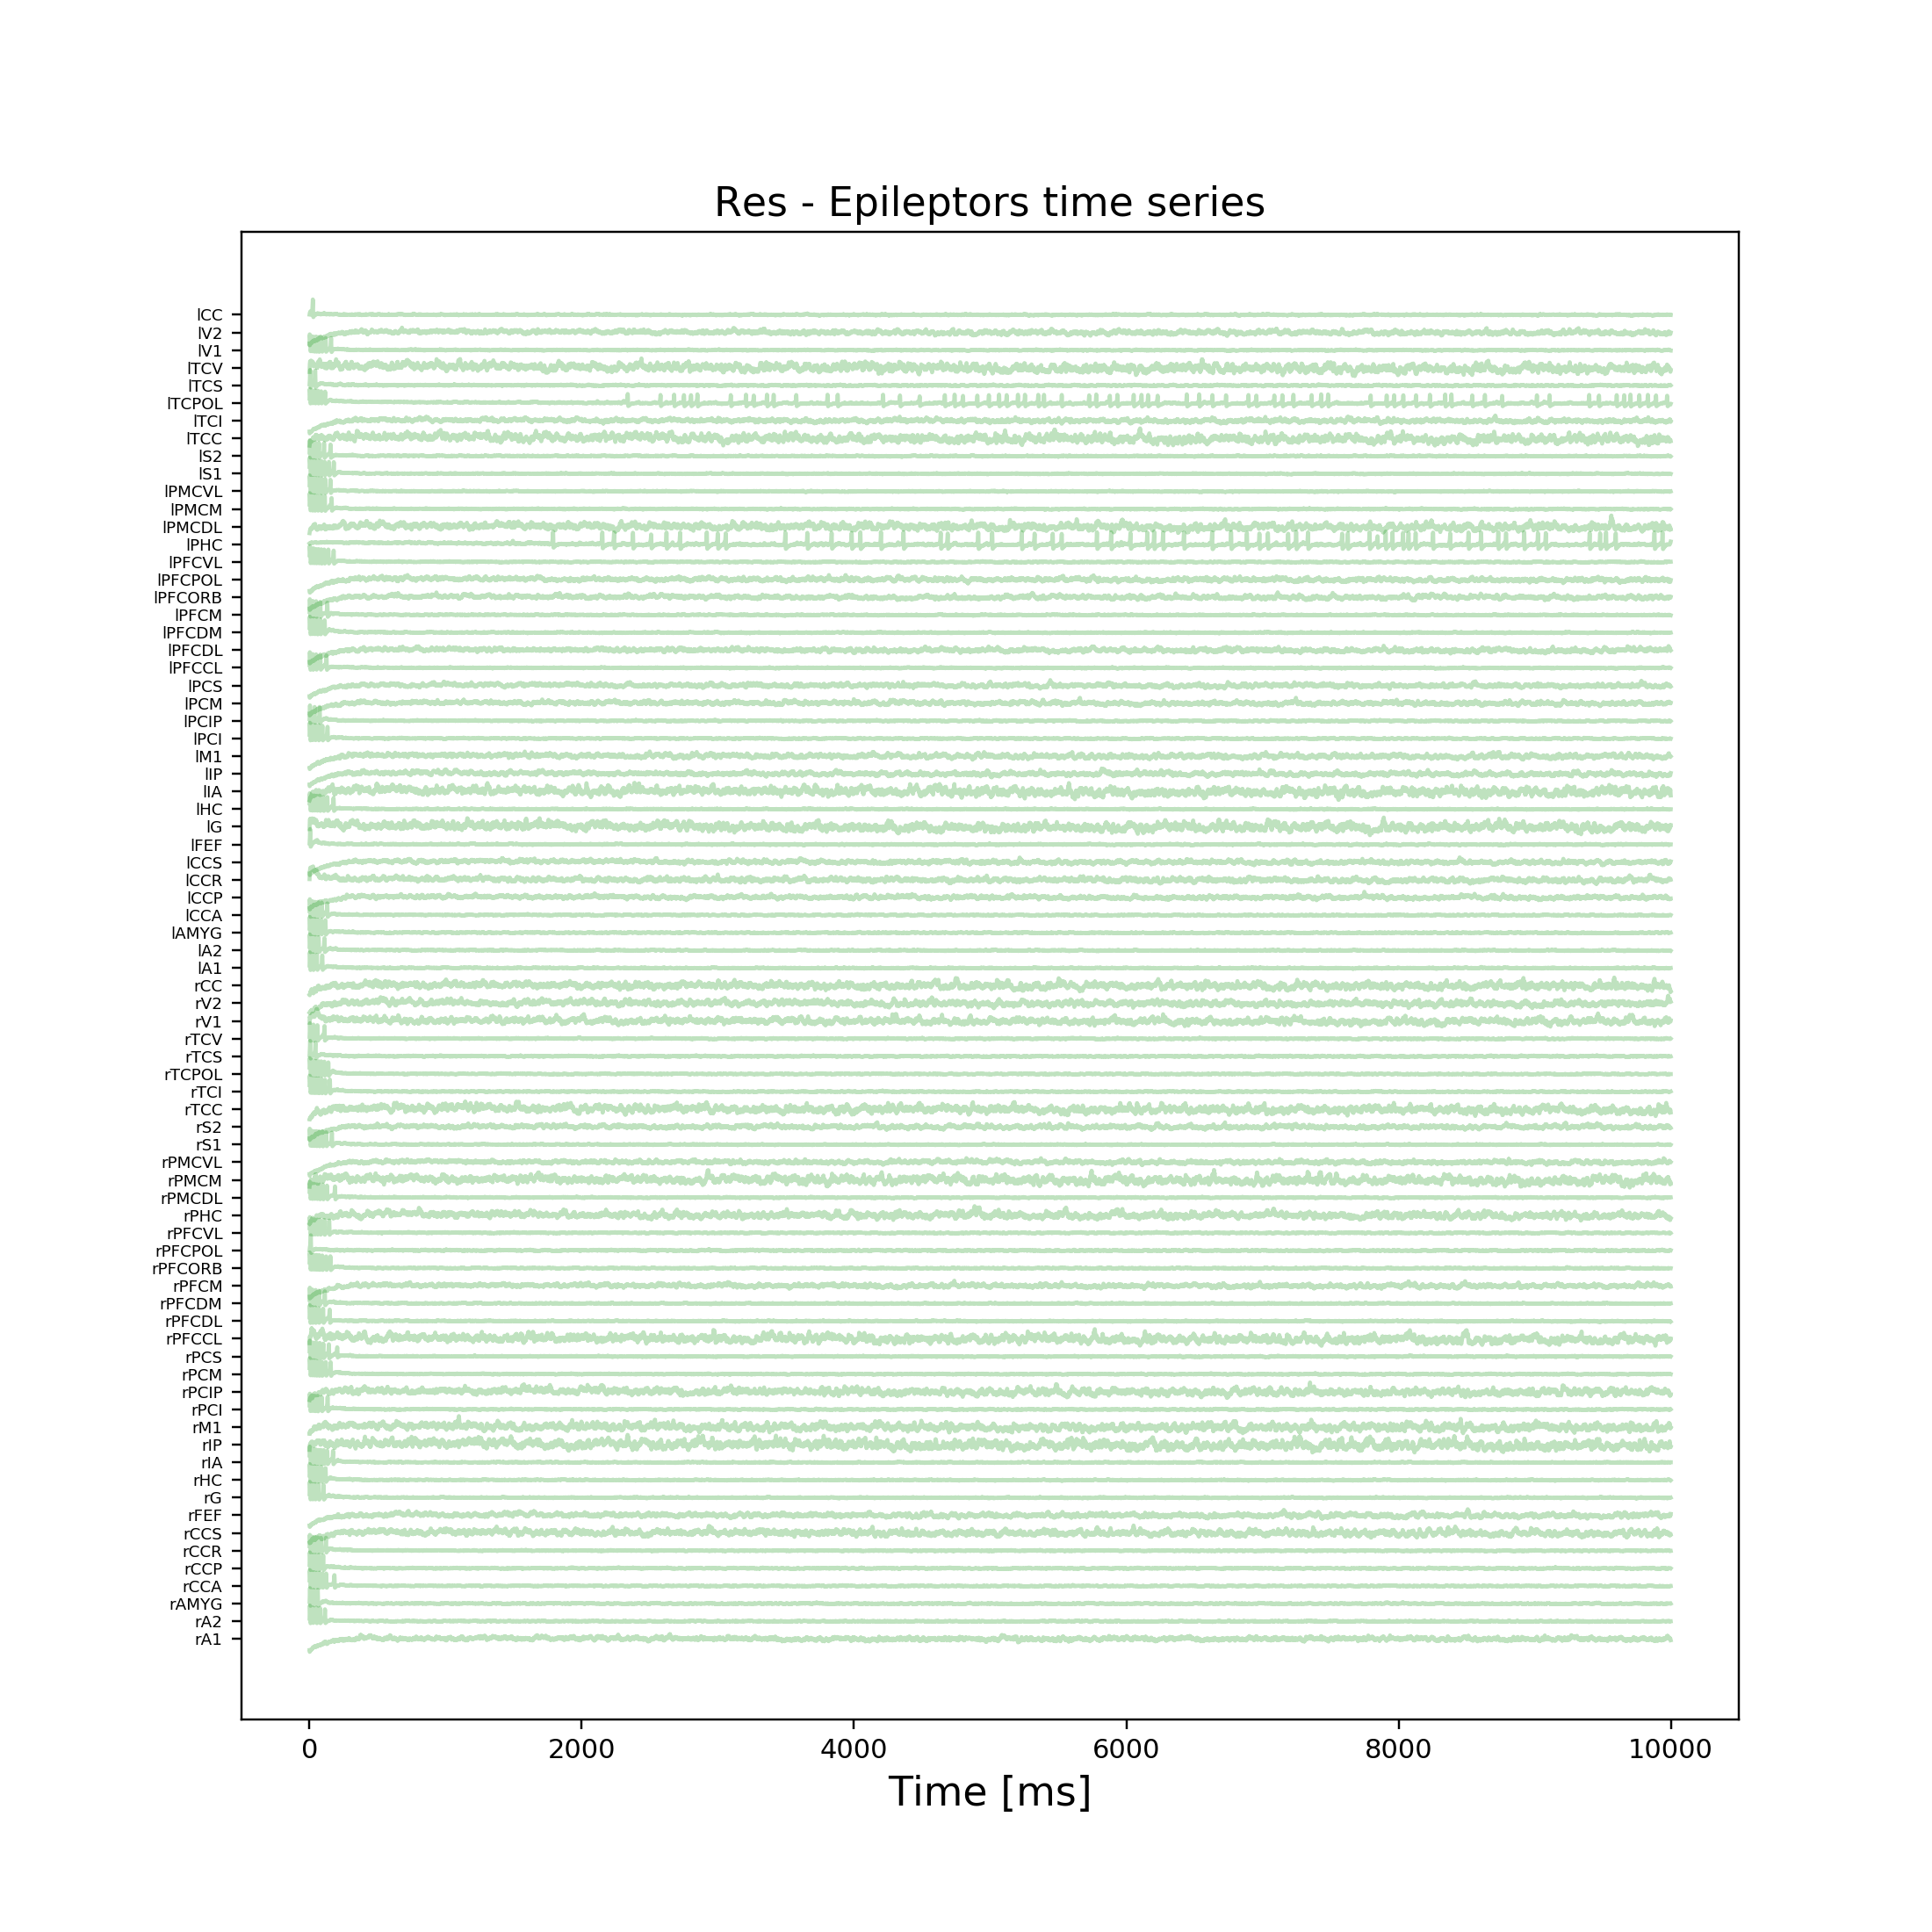

In [127]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)

# Plot time series.
figure(figsize=(10,10))
plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'C2', alpha=0.3)
title('Res - Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)
show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">As you can see, no seizure is triggered anymore.</font></div></p>

<h1><font size="6" face="arial" color="black">3. Triggering a seizure by stimulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We are now going to model an <b>electric stimulation</b> and <b>trigger a seizure</b>. We set the whole brain to non-epileptogenic but the stimulated regions are set closer to the threshold.</font></div></p><br>

<h3 align="left"><font size="5"face="arial" color="black">3.1 Build a stimulus</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We will begin by just arbitrarily selecting some nodes and defining the weighting of the stimuli coming into those nodes, to show what the basic process looks like.</font></div></p>

In [128]:
# Configure stimulus spatial pattern.
nodes = [62, 70]
stim_weights = np.zeros((nregions))
stim_weights[nodes] = np.array([2.0])

<p><div style="text-align: justify"><font size="4.5" face="time roman">We now need to define the temporal profile. This is done by selecting an equation and setting its parameters as desired. </font></div></p>

In [129]:
# Configure stimulus temporal profile.
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 2e3       # onset time [ms]
eqn_t.parameters['T'] = 3000.0        # pulse repetition period [ms]
eqn_t.parameters['tau'] = 100.0       # pulse duration [ms]

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now, we need to combine these spatial and temporal components into a StimuliRegion object, which can then be used in the construction of our simulator:</font></div></p>

In [130]:
# Configure Stimuli object.
stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = con, 
                                  weight =stim_weights)

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can take a quick look at the basic structure of the stimuli we have just defined using one of the built in plotting tools.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The plotting tool we will use provides a simple overview of the stimuli's structure. It assumes the stimulus object is already configured, so we start by configuring the object. This configuration step is actually taken care of automatically within the simulator, so when you don't want to look at your stimuli before running a simulation this step isn't necessary.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"><i>NOTE:</i> while the information necessary to configure space is provided by the Connectivity object, for time it is necessary to explicitly provide a time vector. When a simulation is run, this time vector is generated internally based on the integration scheme's dt and the simulation length requested when you call the simulator.</font></div></p>

<IPython.core.display.Javascript object>


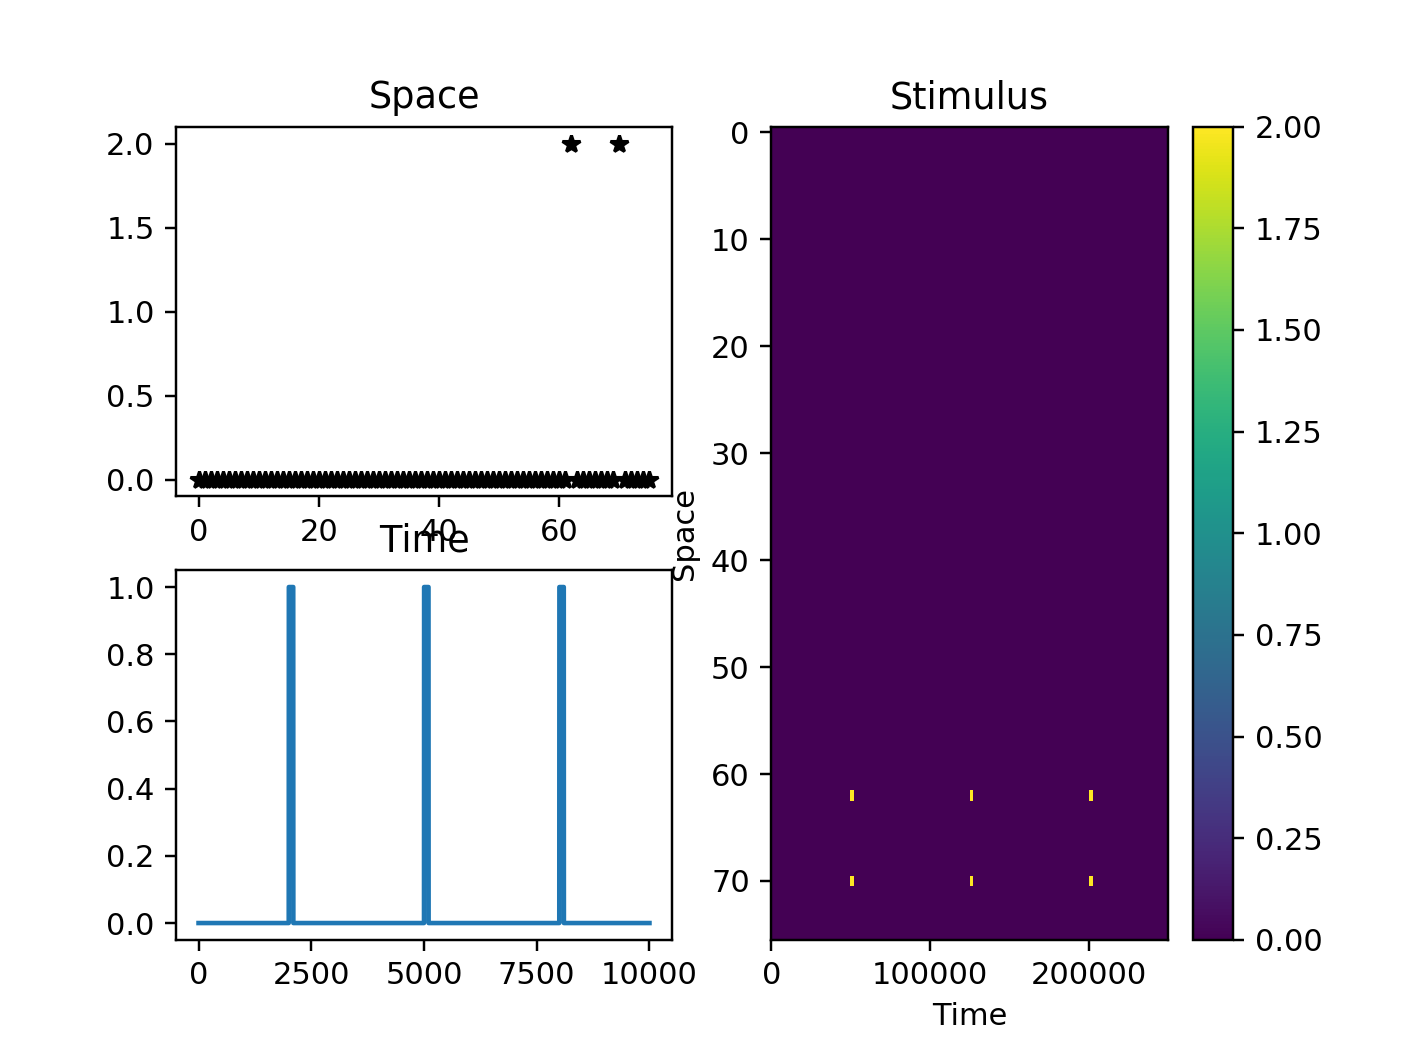

In [131]:
# Configure space and time.
stimulus.configure_space()
stimulus.configure_time(np.arange(0., 10000., 5**-2))

# And take a look
plot_pattern(stimulus)
show()

<h3 align="left"><font size="5"face="arial" color="black">3.2 Simulate</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now, we just configure ...</font></div></p>

In [132]:
# Initialise Model.
epi = models.Epileptor(Ks=1., r=0.00015)
epi.x0 = np.ones(nregions) * (-2.6) 
epi.x0[[62]] = np.ones((1)) * (-1.78)     #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)     #PZ 

# Set initial conditions.
epi.state_variable_range["x1"] = [-1.8, -1.8]
epi.state_variable_range["y1"] = [-15, -15]
epi.state_variable_range["z"] = [3.6, 3.6]
epi.state_variable_range["x2"] = [-1.1, -1.1]
epi.state_variable_range["y2"] = [0.001, 0.001]

In [133]:
# Initialise Simulator.
sim = simulator.Simulator(model=epi, 
                          connectivity=con,
                          coupling=coupling.Difference(a=-0.25), 
                          integrator=integrators.HeunStochastic(dt=0.05, noise=noise.Additive(nsig=np.array([0., 0., 0., 0.00025, 0.00025, 0.]))), 
                          monitors=monitors.TemporalAverage(period=1), 
                          stimulus=stimulus)

sim.configure()

Simulator(bound=False, value=None)

<p><div style="text-align: justify"><font size="4.5" face="time roman">... and run the simulation.</font></div></p>

In [134]:
# Starting simulation
print("Starting simulation...")
tic = tm.time()

(t, tavg), = sim.run(simulation_length=10000)

# Finished simulation.  
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for80.9830541611


<h3 align="left"><font size="5"face="arial" color="black">3.3 Visualize</font></h3>

<IPython.core.display.Javascript object>


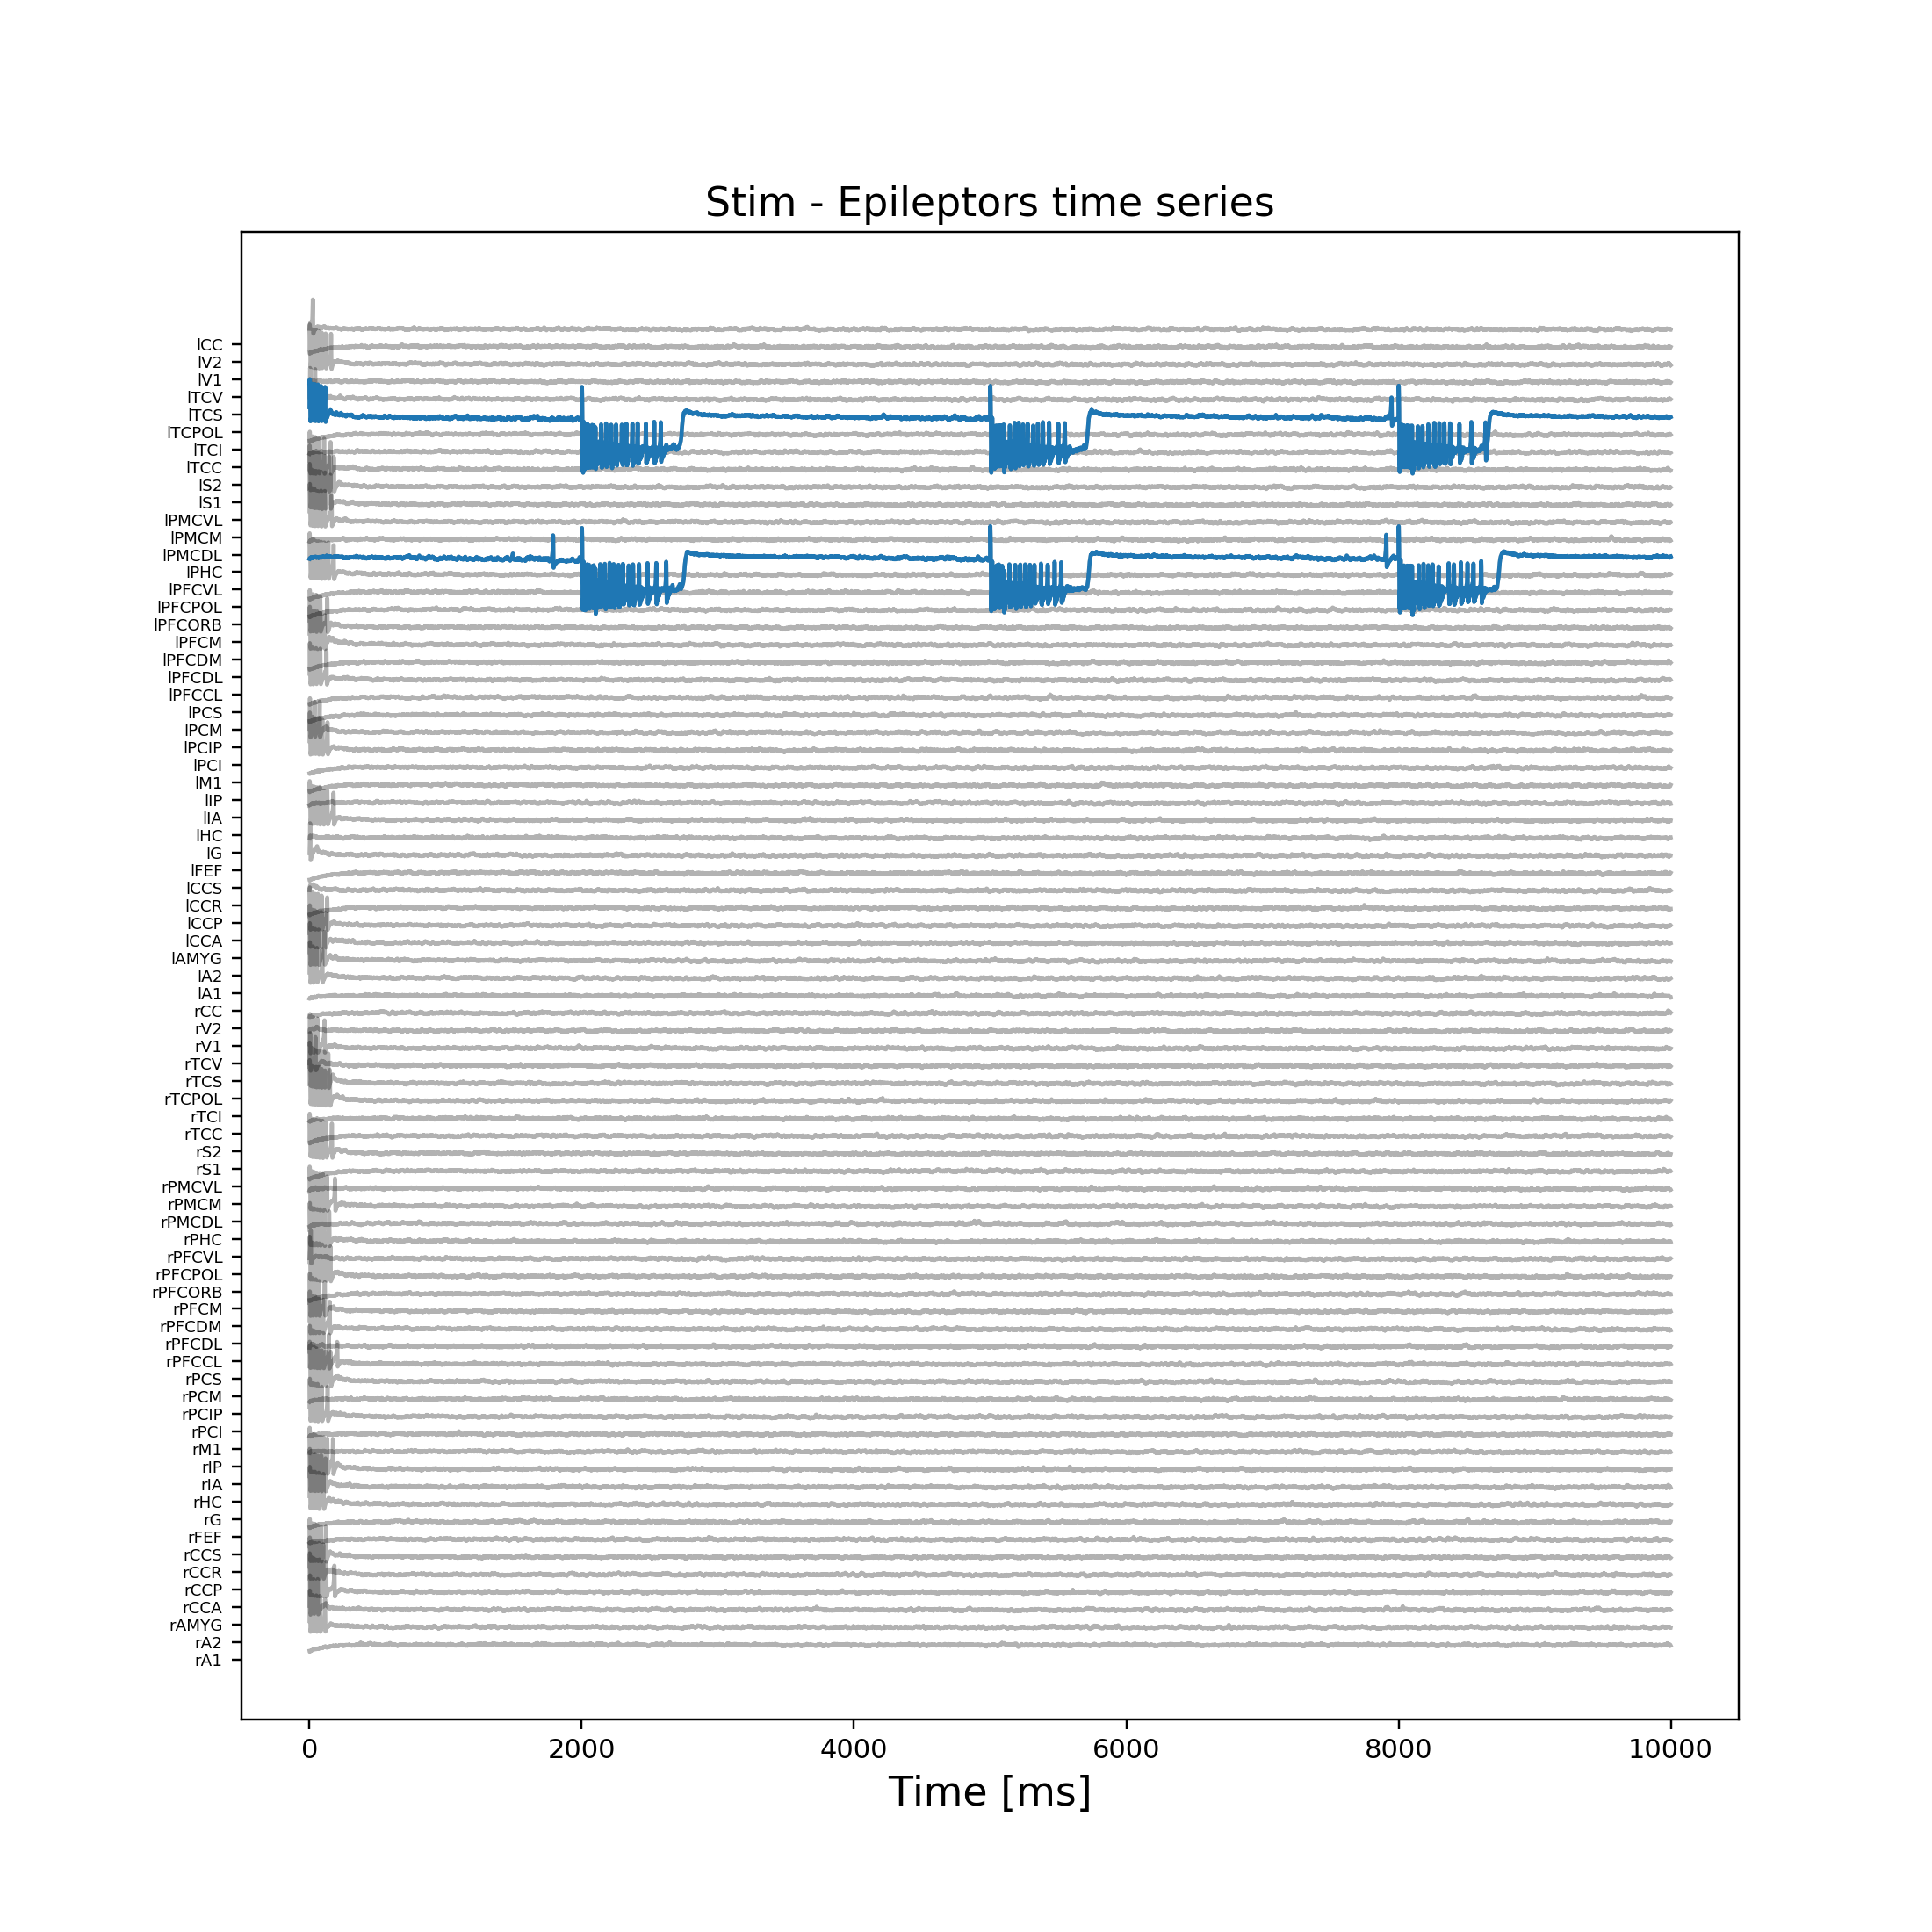

In [135]:
figure(figsize=(10,10))
plot(t[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'k', alpha=0.3)
title('Stim - Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)

for i, node in enumerate(nodes):
    plot(t[:], tavg[:, 0, nodes[i], 0] + nodes[i], 'C0')
    
show()

<h1><font size="6" face="arial" color="#73ACCD">That is all folks</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">We hope this has been a useful tutorial and welcome any comments or questions.</font></div></p>

<br><p><div style="text-align: justify"><font size="4.5" face="time roman"><u>References</u></font></div></p>
* Jirsa et al., 2014: 

Jirsa, V. K.; Stacey, W. C.; Quilichini, P. P.; Ivanov, A. I.; Bernard, C. <b>On the nature of seizure dynamics</b>. <i>Brain</i>, 2014; 137: 2210–30.

* Proix et al., 2014:

Proix, T; Bartolomei, F.; Chauvel, P.; Bernard, C.; Jirsa, V. K. <b>Permittivity coupling across brain regions determines seizure recruitment in partial epilepsy</b>. <i>J of Neurosci</i>, 2014; 34(45):15009 –15021.